# Case Studies for Freeletics

Italo Balestra


In the following I will analyze the two case studies proposed by Freeletics. 

---

## Case 1. 

<i><b> We released a workout logging feature within the Freeletics body-weight application. We want to study its impact on the performance of the social feed loading times (SLFT), where we anticipate the usage of this feature to be X user /Day. We already know that the loading times of the social feed across iOS/Android devices is in the range of Y-Z seconds. Given that we want to monitor the performance of the social feed loading times for the next 24 hours to evaluate the effect of the feature, your task is to: </b></i>

#### a. Choose meaningful numbers for X,Y ,Z.

Here, I will make a rough guess for X based on the current total number of Freeletics users (T = 1.4e7) and an estimate of the possible users of the new feature in the 24h time slot to be sampled. I will assume that 20% of the users are active per day and that 50% of them are using the new feature. This gives X = 1.4e6 users utilizing the new workout logging feature everyday.

For Y and Z, in absence of real data and given my lack of experience with this kind of data, I simply googled to find what the typical loading time of a web page is. That seems to be between 2 and 5 s. I will assume that this is the typical range of loading times of the soacial feed.

#### b. Generate and visualize dummy data that models the scenario above over 24 hours. How did you model user traffic and SFLT? What parameters did you use? Why?

Here, I will assume that the user traffic in a specific geographic region follows a Gaussian distribution peaked around two times of the day: one in the morning at 08:00 and one in the evening at 18:00.

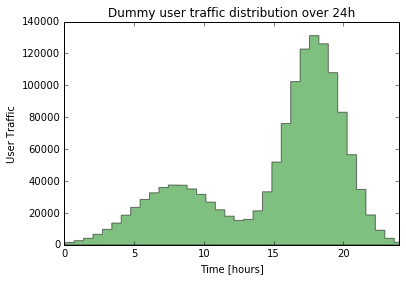

In [1]:
"""
Simulate the user traffic distribution.
"""

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

X = 1.4e6 # Total number of daily users 

# create two Gaussian distributions and add them
g1 = 3 * np.random.randn(X * 0.3) # Gaussian with size = 30% of X and sigma = 3h
g2 = 2 * np.random.randn(X * 0.7 +1) # Gaussian with size = 70% of X and sigma = 2h
user_traff = []
for am in g1:
	user_traff.append(8 + am)
for pm in g2:
	user_traff.append(18 + pm)

fig=plt.figure()
ax=fig.add_subplot(111)
plt.hist(user_traff, bins=50, histtype='stepfilled', facecolor='green', alpha=0.5)
plt.xlabel('Time [hours]')
plt.ylabel('User Traffic')
plt.title('Dummy user traffic distribution over 24h')
ax.set_xlim(0, 24)
plt.show()

For the SFLT, the most likely assumption is that this will follow a log-normal distribution peaked between Y and Z. I will model the log-normal distribution with the parameters that correspond to a pdf that has 95.4% values between Y = 2s and Z = 5s.  

(2.1020278684887548, 5.1109527442075526)


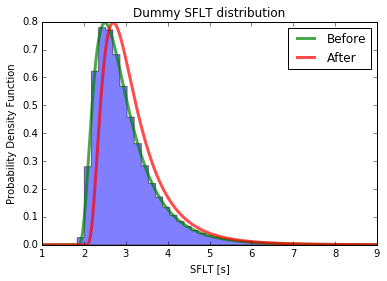

In [2]:
"""
Simulate the SFLT distribution.
"""

from scipy.stats import lognorm

# Create a log-normal distribution for SFLT before the introduction of the new feature
mu, sigma = 1.8, 0.6 # my guess for the mean and standard deviation
ln_dist = lognorm(sigma, loc=mu) 
s = 0.954
print ln_dist.interval(s) # check that 95.4% of values are between Y ~ 2s and Z ~ 5s

SFLT = ln_dist.rvs(size=X)

# Create a log-normal distribution for SFLT after the introduction of the new feature
mu_after = mu + 0.2 # I simply shift the mean by 0.2s
ln_dist_after = lognorm(sigma, loc=mu_after)
SFLT_after = ln_dist_after.rvs(size=X)

x = np.linspace(lognorm.ppf(0.001, s), lognorm.ppf(0.999, s), num = 1000)

fig=plt.figure()
ax=fig.add_subplot(111)
plt.hist(SFLT, bins=100, normed=True, histtype='stepfilled', alpha=0.5)
#plt.plot(x, sflt_pdf)
plt.plot(x, ln_dist.pdf(x), lw=3, alpha=0.7, label='Before')
plt.plot(x, ln_dist_after.pdf(x), lw=3, alpha=0.7, label='After')
plt.xlabel('SFLT [s]')
plt.ylabel('Probability Density Function')
plt.title('Dummy SFLT distribution')
ax.set_xlim(1, 9)
plt.legend()
plt.show()

Most likely, the SFLT will also correlate with user traffic, due to the increased server load during busy hours. For simplicity I simulated data without correlation between traffic and SFLT. To answer the last optional question, I will also add a simple linear correlation between the two parameters when simulating the SFLT (see below).

#### c. Given the dummy data, formulate a hypothesis, to answer the question of “is the feature affecting the SFLT in any way?”

We simulated the data in such a way that the effect of the new feature is that of increasing the SFLT. So, given our dummy data, the answer to the above question is obviously, "yes". If we had no knowledge of the distributions of SFLT before and after the introduction of the new feature, as is the case in the real data, we would have to test the hypothesis that the two distributions (before and after the feature) are equal or not. If they are not equal, the new feature is most likely responsible for a delay in the laoding time.

#### d. Name, setup and explain the test you would perform to test this hypothesis.

The most appropriate test to be performed in this case would be the Kolmogorov–Smirnov test, which is non-parametric and does not assume a normal distribution. We could use the 2-sample test, which is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution. We expect to obtain a large K-S statistic value and a small p-value, which indicate that the distributions of the two samples are different.

#### e. Implement the set of formulas that you would need to validate the hypothesis.

This can be simply done as follows:

In [3]:
from scipy import stats

stats.ks_2samp(SFLT_after, SFLT)

Ks_2sampResult(statistic=0.15741285714285713, pvalue=0.0)

As expected the two distributions are different. In general, if the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same. For example, a p-value = 0.10 would tell us that the we cannot reject the null hypothesis that the 2 distributions are the same with a 10% probability.

#### f. Should we roll back this feature? Why? Why not? Please provide a set of numbers that you used for this decision.

We know from our simulated data that the new feature has caused an increase of the SFLT. Now, the question is: would the increased SFLT be "tolerable"? One could consider it "tolerable" if the mean loading time does not increase by more than 1 sigma. In our case this is true, which means we can consider the new feature acceptable. 

#### g. Provide a visualization that shows SFLT over time [hours] with appropriate confidence intervals.

First, we will assume that the SFLT and user traffic are uncorrelated. Here, I simply couple the traffic hour and the SFLT data randomly. Then I bin the data in time and I calculate the mean and the confidence intervals in each time bin.

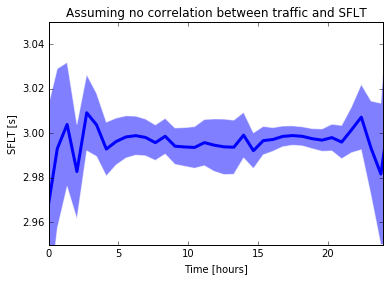

In [4]:
n, edg = np.histogram(user_traff, bins=48)
sy, edg = np.histogram(user_traff, bins=48, weights=SFLT)
sy2, edg = np.histogram(user_traff, bins=48, weights=SFLT**2)
mean = sy / n
std = np.sqrt(sy2/n - mean**2)/np.sqrt(n)

plt.fill_between((edg[1:] + edg[:-1])/2, mean-2*std, mean+2*std, alpha=0.5, edgecolor = 'white')
plt.plot((edg[1:] + edg[:-1])/2, mean, 'b-', lw=3)
plt.axis([0, 24, 2.95, 3.05])
plt.xlabel('Time [hours]')
plt.ylabel('SFLT [s]')
plt.title('Assuming no correlation between traffic and SFLT')

plt.show()

As expected, there is no trend between user traffic and SFLT. 

#### h. Optional: is there a correlation between traffic and SFLT? How would you prove it? What would that indicate?

Since the simulated data have been created without any correlation between these two parameters, we correctly find no dependency of the SFLT from the user traffic in the plot above. To find a correlation we would first have to model that in the simulated data and then sort the binned data by increasing traffic, using the size of the array in each bin.